In [ ]:
# NOTE: if opened with Colab execute this cell
!git clone https://github.com/BoCtrl-C/attention-rollout.git
!mv attention-rollout/* ./
!rm -r attention-rollout

In [1]:
from attention_rollout import show_attention, show_images
from vision_transformer import vit_b_16

from nltk.corpus import wordnet as wn

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, CenterCrop,\
    Normalize

/home/tommaso/miniconda3/envs/saint_env/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# BATCH_SIZE = 8
# SEED = 3

# g = torch.Generator()

# # load the ImageNet validation split
# dataset = ImageFolder(
#     'datasets/ILSVRC/Data/CLS-LOC/val_folders',
#     transform=Compose([ # pre-processing required by the pre-trained ViT
#         Resize(256),
#         CenterCrop(224),
#         ToTensor(),
#         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
# )
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
#     generator=g.manual_seed(SEED))

# g_vis = torch.Generator()

# vis_dataset = ImageFolder(
#     'datasets/ILSVRC/Data/CLS-LOC/val_folders',
#     transform=Compose([ # pre-processing for visualization
#         Resize(256),
#         CenterCrop(224),
#         ToTensor()
#     ])
# )
# vis_dataloader = DataLoader(vis_dataset, batch_size=BATCH_SIZE, shuffle=True,
#     generator=g_vis.manual_seed(SEED))

# x, y = next(iter(dataloader))
# x_vis, _ = next(iter(vis_dataloader))

# # save the sampled batch on a file
# torch.save((x, x_vis, y), 'data/batch')

# # save ImageNet classes on a file
# torch.save(dataset.classes, 'data/classes')

# load a batch of ImageNet images
# NOTE: the code above has been used to sample the loaded batch
x, x_vis, y = torch.load('data/batch')

# load ImageNet classes
classes = torch.load('data/classes')

In [3]:
# load the pre-trained ViT
device = torch.device('cuda:0')
model = vit_b_16(weights='IMAGENET1K_SWAG_LINEAR_V1').to(device)

In [4]:
# predict classes
p = model(x.to(device))
y_prime = p.argmax(dim=-1)

# retrieve attention matrices
As = []
for layer in model.encoder.layers:
    As.append(layer.attn_output_weights.detach())

##### Attention Rollout

Let's consider all paths between an output and an input position:
- Edge weights on the same path are multiplied togheter.
- The contribution of each path is additive.

Hence, attention weights matrices are recursively multiplied according to:
$$\tilde{A}(l_i) =
\begin{cases}
\begin{align}
A(l_i)\tilde{A}(l_{i - 1})\quad &\text{if}\ i > j\nonumber\\
A(l_i)\quad &\text{if}\ i = j\nonumber
\end{align}
\end{cases}\\
A = 0.5W_{att} + 0.5I$$
where $\tilde{A}(l_i)$ is the attention rollout and $W_{att}$ is the attention
matrix of layer $i$, which is denoted by $l_i$. In this notebook, the first
layer is indexed by $i = 0$.

In [ ]:
# TODO: complete the following function
def attention_rollout(As):
    """Computes attention rollout from the given list of attention matrices.
    https://arxiv.org/abs/2005.00928
    """

    # TODO: write here
    ...

    return rollout

In [ ]:
# rollout attention
cls_rollout = attention_rollout(As)[:,0,1:] # classification head to patches
cls_rollout = F.upsample(cls_rollout.view(-1, 1, 14, 14), (224, 224),
    mode='bicubic') # upsample to original image size

# show results
show_images(x_vis, figsize=(20, 20))
show_attention(x_vis, cls_rollout, figsize=(20, 20))
print([wn.synset_from_pos_and_offset('n',
    int(classes[i][1:])).lemma_names()[0] for i in y_prime])

/home/tommaso/miniconda3/envs/saint_env/lib/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


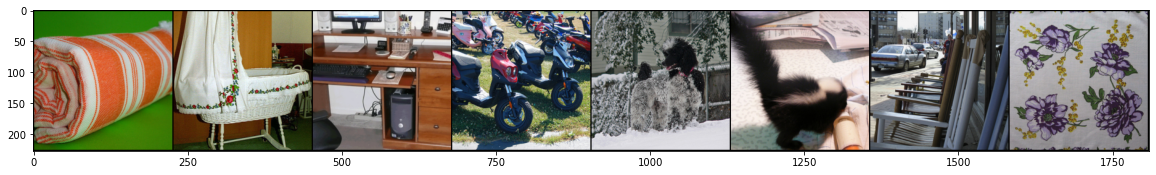

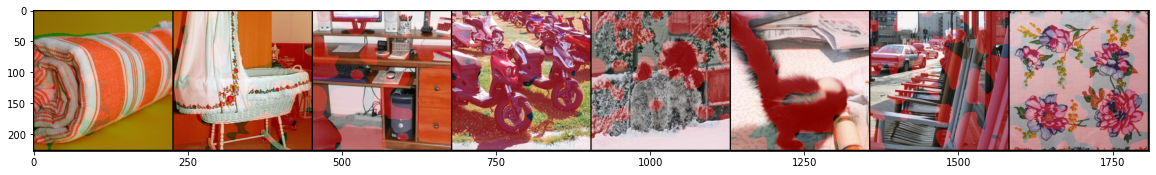

['bath_towel', 'cradle', 'desktop_computer', 'motor_scooter', 'standard_poodle', 'skunk', 'crutch', 'handkerchief']


In [5]:
# import the correct implementation of attention rollout
from attention_rollout import attention_rollout

# rollout attention
cls_rollout = attention_rollout(As)[:,0,1:] # classification head to patches
cls_rollout = F.upsample(cls_rollout.view(-1, 1, 14, 14), (224, 224),
    mode='bicubic') # upsample to original image size

# show results
show_images(x_vis, figsize=(20, 20))
show_attention(x_vis, cls_rollout, figsize=(20, 20))
print([wn.synset_from_pos_and_offset('n',
    int(classes[i][1:])).lemma_names()[0] for i in y_prime])